* This notebook targets at 

1) the transition from near- to far-field under three wind event conditions.
2) testing if Rmix is reasonable in defining near and far fiel.
3) Compare the near and far field defined by Rmix with that by Froude number.

In [46]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import pytz 
import StraTimeSeries as sts
import R_mixStuff as RS
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [71]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
## umask
umask = mesh.variables['umask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]

In [3]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc','r')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc','r')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc','r')
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc','r')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc','r')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc','r')
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')

* transect

-123.293


(48.95, 49.3)

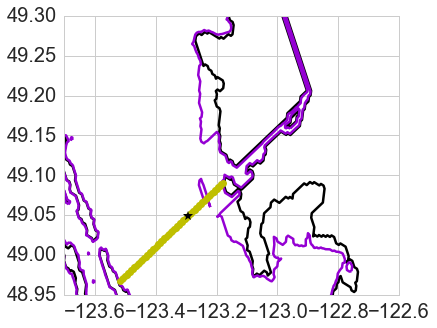

In [4]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:70],lat[36,4:70],'yo') ## transect
ax.plot(lon[36,47],lat[36,47],'k*',markersize = 10) ## station
print(lon[36,47])
ax.set_xlim([-123.7,-122.6])
ax.set_ylim([48.95,49.3])

* determine plume salinity, with $S_{offset} = 4.8 - 0.14\times{S_{ref}}$, the threshold works.

In [12]:
def determine_plume_method2(tst,ted,dep_ind,err):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 5*5 km in the northern of my subdomain"""
    fig, axs = plt.subplots(1,2,figsize= (16,5))
    S = all_T.variables['vosaline']
    S_aveN = np.nanmean(S[tst:ted,:,-10:,0:10],axis = 0) ## first temporal average of northern region
    S_aveT =np.nanmean(S[tst:ted,:,36,4:70],axis = 0) ## temporal average of the transect
    jinds = np.arange(4,70)
    iinds = np.arange(36,37)
    ax = axs[0] ## plot salinity along transect
    ax.plot(jinds,S_aveT[dep_ind,:])
    ax.set_ylim([0,30])
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    for i in np.arange(S_aveT.shape[1]):
        if abs(S_aveT[dep_ind,i] -S_thre)<= err:
            print('i,lon,real salinity',i,lon[36,i], S_aveT[dep_ind,i])
    print('S_ref',S_ref)
    print('S_thre',S_thre)
    ax.plot([0,70],[S_thre,S_thre],'g--')
    ax.set_xlabel('Index to west coast')
    ax.set_ylabel('Practical Salinity')
    ax = axs[1] ## salinity contour in the whole subdomain
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    mesh = ax.contourf(lon[:],lat[:],S_aveW[:],cmap = 'jet')
    cbar=fig.colorbar(mesh)
    ax.plot(lon[36,4:70],lat[36,4:70],'go') ## transect
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])

S_ref 26.4423
S_thre 25.344240303
(130, 157)


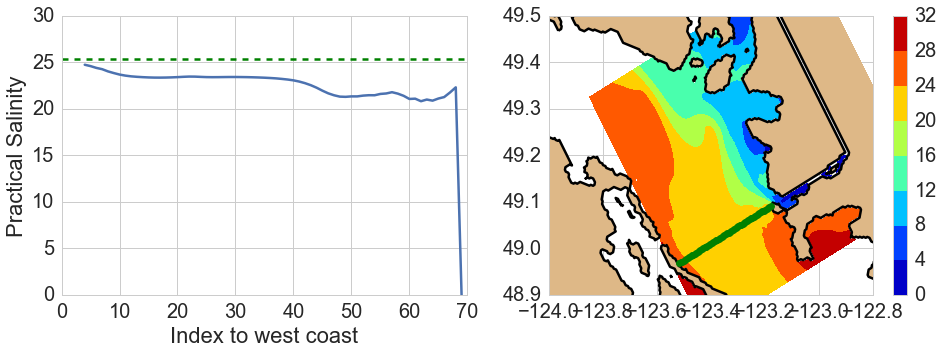

In [9]:
## weak wind + neap tides:
determine_plume_method2(48,143,0,0.1)

i,lon,real salinity 52 -123.267 26.8772
S_ref 27.8619
S_thre 26.9625728989


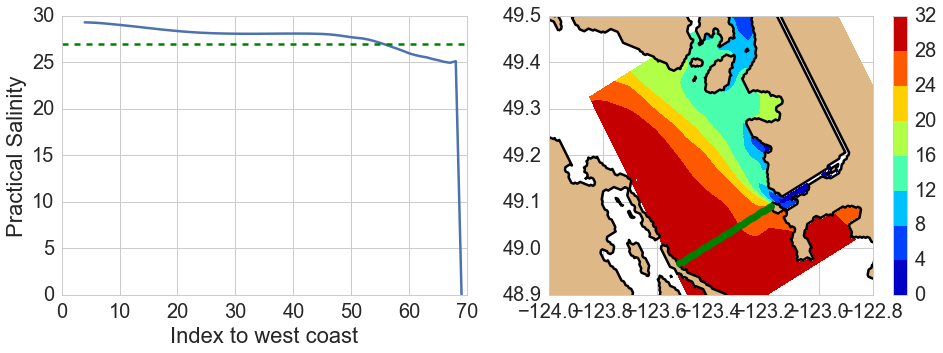

In [13]:
## moderate wind + neap tides:
determine_plume_method2(408,479,0,0.1)

i,lon,real salinity 44 -123.309 28.1728
i,lon,real salinity 45 -123.303 28.0463
S_ref 28.8626
S_thre 28.1033078384


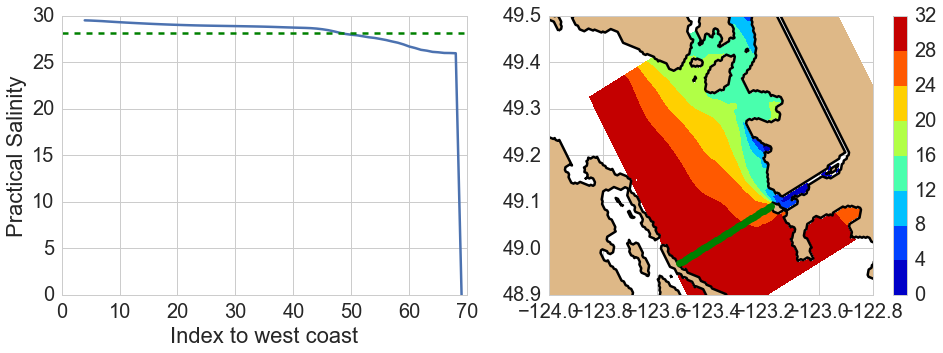

In [14]:
## strong wind + neap tides:
determine_plume_method2(480,551,0,0.1)

* Use Rmix to define near and far field on the transect

In [22]:
def threshold_near_far(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,np_mask,dep_ind):
    """This function is made to select the 
    transition from near to far field in the plume by
    criteria of Rmix(river+wind)/Rmix(all) >=0.9 and 
    Rmix(river+tide)/Rmix(all) <=0.7"""
    far_rmix_wind = [];
    far_rmix_tide = [];
    far_lon = []; iss =[];
    f, rmix = RS.plot_Rmix_together(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,np_mask,dep_ind)
    fig, ax = plt.subplots(1,1,figsize = (14,3))
    for i in np.arange(4,70):
        if (rmix['river+winds'][36,i]/rmix['all'][36,i] >= 0.9) and \
        (rmix['river+tides'][36,i]/rmix['all'][36,i] <= 0.7):
            ax.plot(lon[36,i],rmix['river+winds'][36,i],'g*',markersize = 10)
            ax.plot(lon[36,i],rmix['all'][36,i],'y*',markersize = 10)
            ax.plot(lon[36,i],rmix['river+tides'][36,i],'b*',markersize = 10)
            far_rmix_wind.append(rmix['river+winds'][36,i])
            far_rmix_tide.append(rmix['river+tides'][36,i])
            far_lon.append(lon[36,i])
            iss.append(i)
    ax.set_xlim([-123.55,-123.15])
    return far_rmix_wind,far_rmix_tide,far_lon,iss

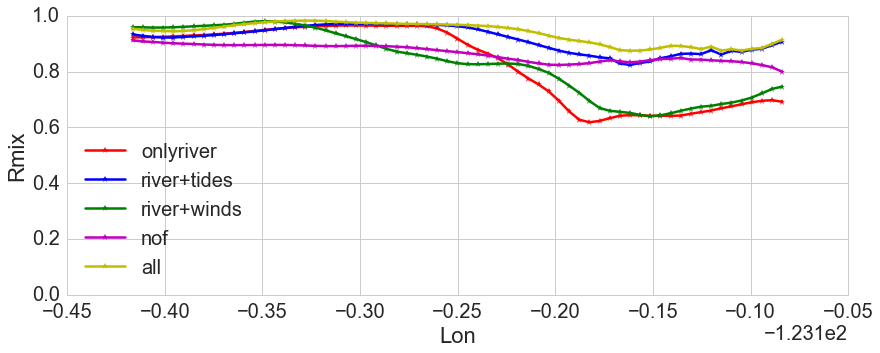

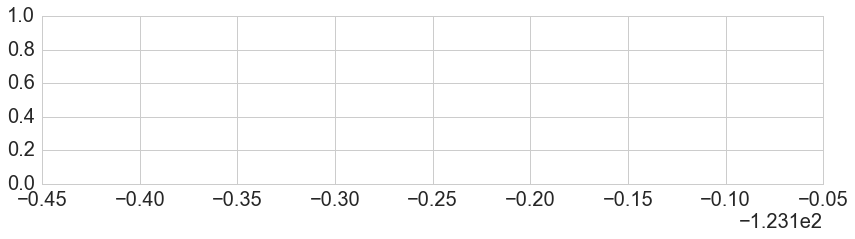

In [23]:
## weak winds +neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,48,143,np_mask,4)

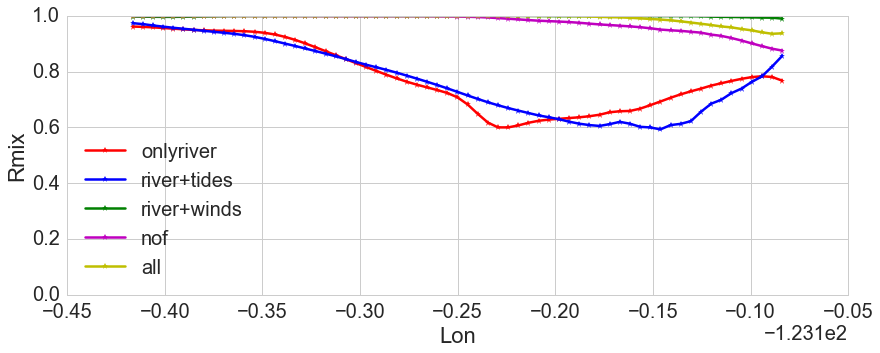

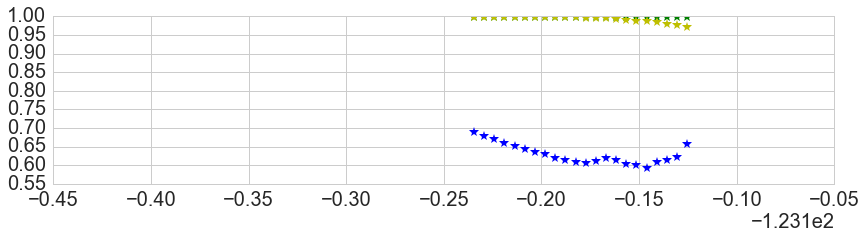

In [24]:
## moderate winds +neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,408,479,np_mask,4)

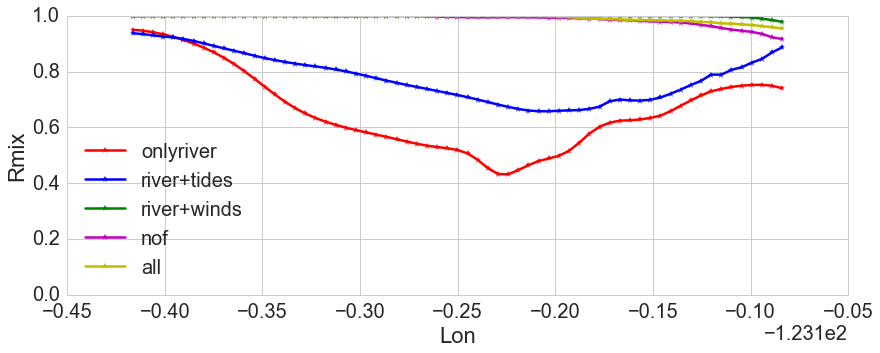

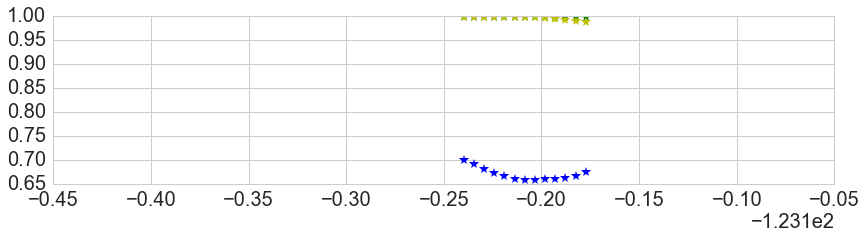

In [25]:
## strong winds+ neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,480,551,np_mask,4)

In [33]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [66]:
def threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind,strings):
    """This function was made to apply the near, far field threshold into the 
    whole domain and look at the range of near and far field plume."""
    rmix = get_Rmix(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind)
    r_wind = rmix['river+winds']/rmix['all']
    r_tide = rmix['river+tides']/rmix['all']
    levels = [0.1,0.3,0.5,0.7,0.9]
    origin = 'lower'
    fig, axs = plt.subplots(1,2,figsize = (15,5))
    for ax, r,ti in zip([axs[0],axs[1]],[r_wind,r_tide],strings):
        CS = ax.contourf(lon[:],lat[:],r[:],levels,cmap = 'jet',origin=origin,
                   extend='both')
        CS2 = ax.contour(CS,levels=CS.levels,colors = 'k',  origin=origin,
                  hold='on',linewidths=(3,))
        plt.clabel(CS2,fmt='%2.1f', colors='g',fontsize = 14)
        cbar = fig.colorbar(CS,ax = ax)
        cbar.add_lines(CS2)
        cbar.ax.set_ylabel('Rmix')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ax.set_title()

In [70]:
strings = ['rmix(wind)/rmix(all)','rmix(tide)/rmix(all)']

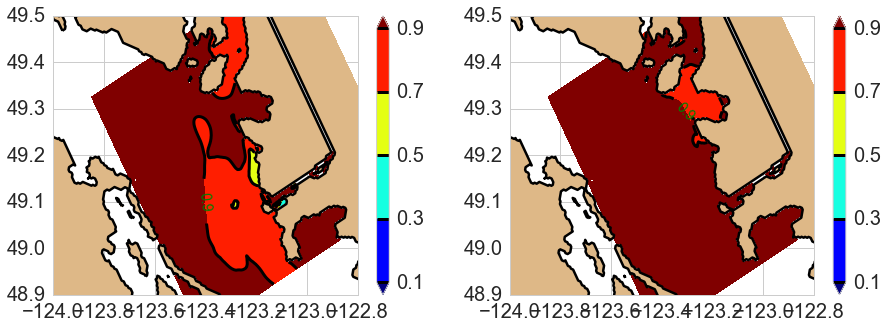

In [67]:
## the whole domain, weak winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,48,143,4,strings = strings)

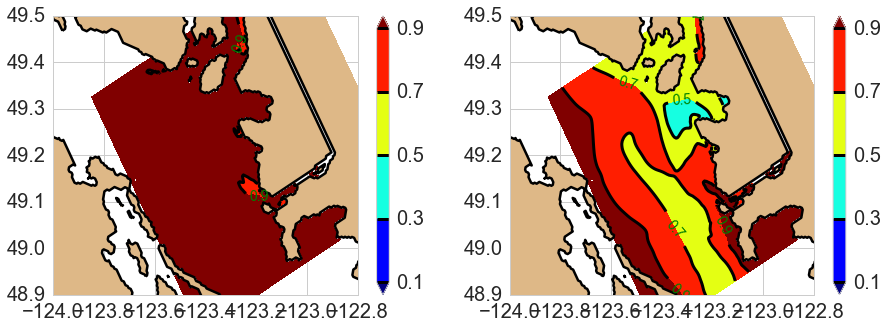

In [68]:
## the whole domain, moderate winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,408,479,4,strings = strings)

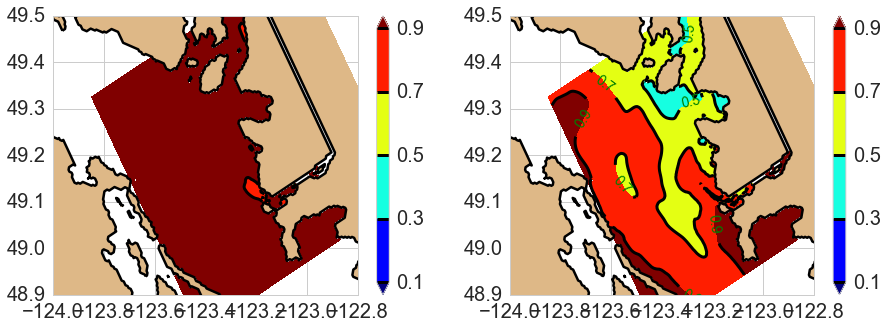

In [69]:
## the whole domain, strong winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,480,551,4,strings = strings)

* By employing Froude number to define near and far field.

* According to Hetland 2005, $Fr = \frac{u}{\sqrt{g^{'}h}}$, where $u=\int_{-h}^{\eta}\abs[u] dz$,
$g^{'} = g \frac{\Delta\rho}{\rho_{0}}$, $\Delta\rho = \rho_{0} - \frac{\int_{-h}^{\eta}\rho\abs{u}dz}{\int_{-h}^{\eta}\abs{u}dz}$

In [ ]:
def Fr_No():
    """This function was made to calculate the Froude number 
    defined above """
    u = 